# Monet Image Generation with GANs

I Will be following Amy Jang's [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial) for this notebook. I will play around with the generator part of the model to see how the outcome changes with different architecture. This is an image generation / style transfer project. Out objective is to create 7000 Monet-esque images. We have access to 300 Monet paintings and more than 7000 regular photographs. We can either generate Monet-esque photos from scratch or transfer the style onto the photo dataset. I will be transfering the style for this project using GANs. 

## EDA

As stated above, there are 300 Monet paintings and about 7000 photographs in the dataset. The images are 256 by 256 RGB pixels. We will import the datasets using the code below. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [4]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [6]:
import random
import matplotlib.pyplot as plt

def view_samples(dataset, n):
    cols = 5
    rows = n // cols
    sample = random.sample(list(dataset), n)
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(7, 7*rows/cols))
    
    for i, img in enumerate(sample):
        row = i // cols
        col = i % cols
        ax[row, col].imshow(img[0]*0.5 + 0.5)
        ax[row, col].axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


Below are some of the sample images from the datasets. The aim is to transfer the art style of Monet onto the regular scenic photographs below.

Monet Examples


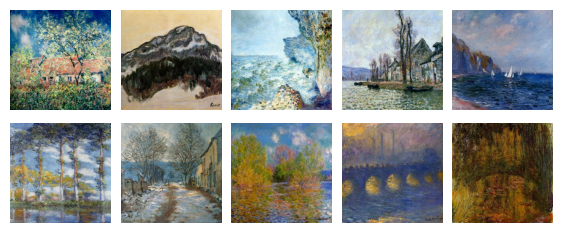

Photo Examples


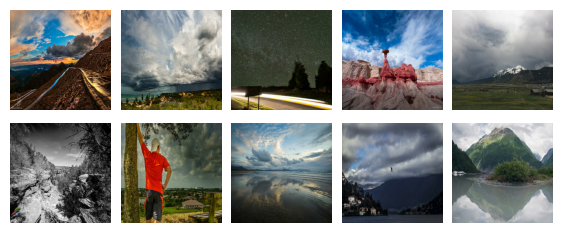

In [7]:
print('Monet Examples')
view_samples(monet_ds, 10)
print('Photo Examples')
view_samples(photo_ds, 10)

## Model Building

CycleGAN is a type of Generative Adversarial Network (GAN) designed for unsupervised image-to-image translation. It can learn to transform images from one domain to another without the need for paired data in the training set. CycleGAN relies on two main components, a generator and a discriminator. The generator is responsible for creating ans transforming the image and the discriminator distinguishes between real and fake images. The tutorial notebook uses a Unet architecture for the generator but I will see what happens when we use a ResNet instead. 

In [8]:
def resnet_block(x, filters, kernel_size=3, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    res = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    res = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(res)
    res = layers.ReLU()(res)

    if apply_dropout:
        res = layers.Dropout(0.5)(res)

    res = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer=initializer, use_bias=False)(res)
    res = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(res)

        if x.shape[3] != res.shape[3]:
        x = layers.Conv2D(filters, 1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    
    return layers.Add()([x, res])

def ResNetGenerator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Initial convolution block
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2D(64, 7, padding='same', kernel_initializer=initializer, use_bias=False)(inputs)
    x = tfa.layers.InstanceNormalization(gamma_initializer=initializer)(x)
    x = layers.ReLU()(x)

    # Downsampling through ResNet blocks
    downsample_blocks = [
        resnet_block(x, 128),  # Output: (256, 256, 128)
        resnet_block(x, 256),  # Output: (256, 256, 256)
        resnet_block(x, 512),  # Output: (256, 256, 512)
    ]

    # ResNet blocks
    for block in downsample_blocks:
        x = block

    # Upsampling through ResNet blocks
    upsample_blocks = [
        resnet_block(x, 256, apply_dropout=True),  # Output: (256, 256, 256)
        resnet_block(x, 128, apply_dropout=True),  # Output: (256, 256, 128)
        resnet_block(x, 64),  # Output: (256, 256, 64)
    ]

    # Upsampling
    for block in upsample_blocks:
        x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
        x = block

    # Final convolution layer
    x = layers.Conv2D(3, 7, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    outputs = tf.keras.activations.tanh(x)  # Output range: [-1, 1]

    return keras.Model(inputs=inputs, outputs=outputs)

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
with strategy.scope():
    monet_generator = ResNetGenerator() # transforms photos to Monet-esque paintings
    photo_generator = ResNetGenerator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

/usr/local/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [13]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [14]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.5)
    
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [15]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=15,
)

Epoch 1/15


2023-10-10 05:29:31.761456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-10 05:29:32.443687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 353s 758ms/step - monet_gen_loss: 9.0358 - photo_gen_loss: 9.4021 - monet_disc_loss: 0.6845 - photo_disc_loss: 0.6823
Epoch 2/15
300/300 [==============================] - 227s 756ms/step - monet_gen_loss: 7.7394 - photo_gen_loss: 7.9219 - monet_disc_loss: 0.6385 - photo_disc_loss: 0.6338
Epoch 3/15
300/300 [==============================] - 227s 756ms/step - monet_gen_loss: 7.3953 - photo_gen_loss: 7.5768 - monet_disc_loss: 0.6612 - photo_disc_loss: 0.6177
Epoch 4/15
300/300 [==============================] - 227s 757ms/step - monet_gen_loss: 7.0428 - photo_gen_loss: 7.1561 - monet_disc_loss: 0.6720 - photo_disc_loss: 0.6738
Epoch 5/15
300/300 [==============================] - 227s 757ms/step - monet_gen_loss: 6.9539 - photo_gen_loss: 7.0128 - monet_disc_loss: 0.6073 - photo_disc_loss: 0.6703
Epoch 6/15
300/300 [==============================] - 227s 756ms/step - monet_gen_loss: 6.9192 - photo_gen_loss: 6.9703 - monet_disc_loss: 0.5971 - pho

## Results

Some sample style transfers are shown below. We can see that the color palette of the new images more closely resemble that of the real Monet paintings. I only trained the model for 15 epochs due to time contraints but longer training could improve the results further. 

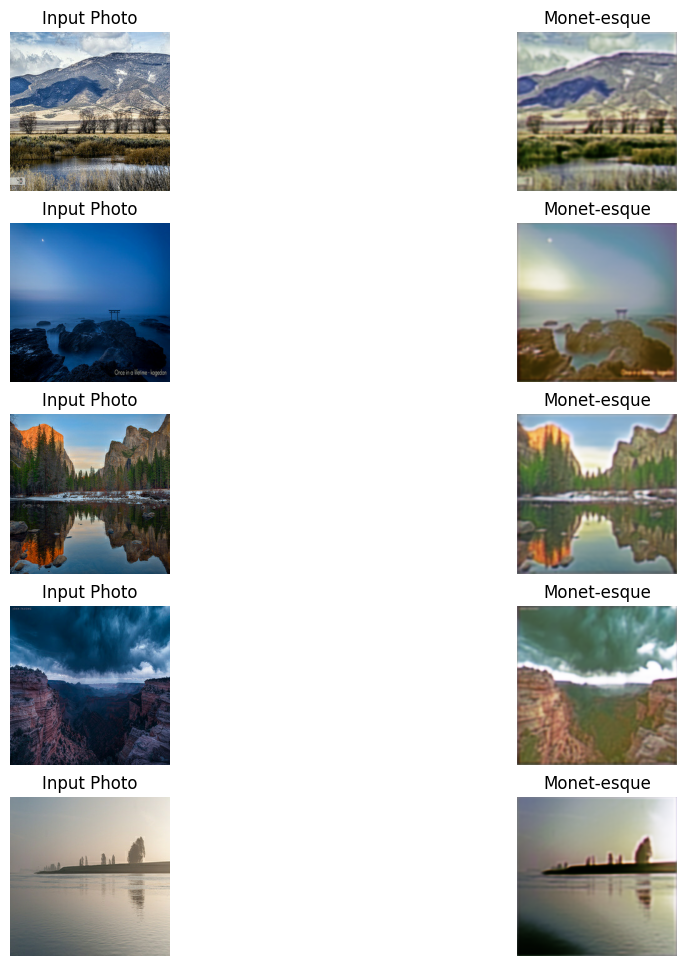

In [16]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Submission

In [17]:
import PIL
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [ ]:
from IPython.display import clear_output
i = 1
for img in photo_ds:
    print(i)
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    clear_output(wait=True)

5448


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

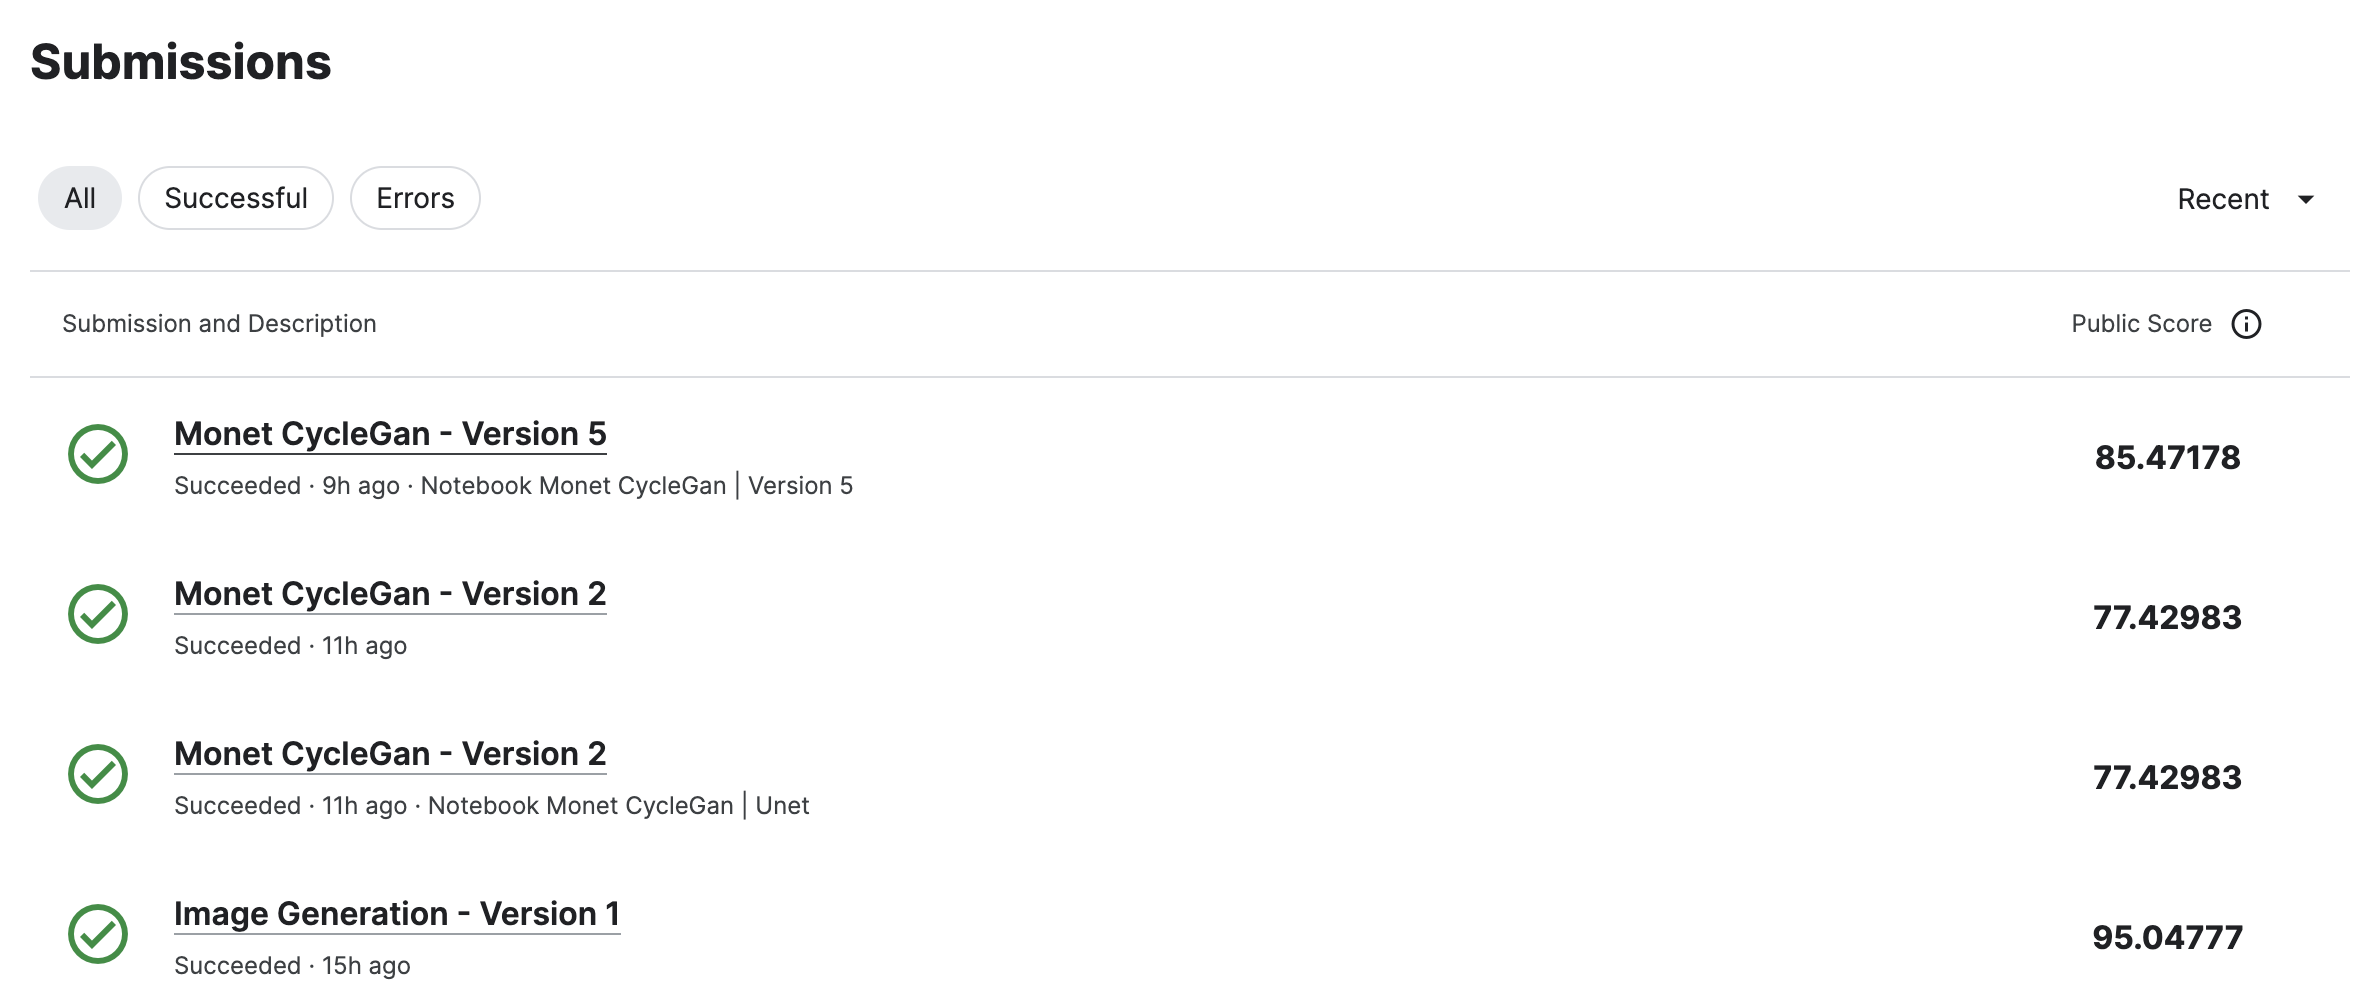

The submission results are shown above where the ResNet generator is the most recent submission. I was able to achieve a higher score with a simpler Unet architecture than the tutorial but I found the results did not look similar to the Monet paintings. This most recent submission had a higher score than the baseline and also looked better in my opinion. 